## Agent-based modeling and simulation of transport flows in Amsterdam
### This notebook handles the preprocessing of GVB data to deduce a population that can be used in an agent-based simulation of public transport in Amsterdam.

#### Load all packages

In [2]:
import networkx as nx
import warnings
import datetime
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

#### Load data for origin and destination per hour

In [3]:
origin = pd.read_csv('../../Data/20190403/Datalab_Reis_Herkomst_Uur_20190403.csv', sep=';')
origin = origin.dropna()
destination = pd.read_csv('../../Data/20190403/Datalab_Reis_Bestemming_Uur_20190402.csv', sep=';')
destination = destination.dropna()

In [4]:
# List of all stations in the sub-network
stations = ['Amsteldijk','Amstelstation','Amstelveenseweg','Beethovenstraat','Bullewijk','Burg.de Vlugtlaan', 
    'Centraal Station','Cornelis Troostplein','Dam','De Boelelaan/VU','De Pijp','Europaplein',
    'Gaasperplas','Gein','Gerrit v.d. Veenstraat','Heemstedestraat','Henk Sneevlietweg','IJsbaanpad', 
    'Isolatorweg','Jan v.Galenstraat','Keizersgracht','Koningsplein','Kraaienneststation','Leidseplein',
    'Maasstraat','Marie Heinekenplein','Minervaplein','Muntplein','Museumplein','Nieuwezijds Kolk',
    'Nieuwmarkt','Noord','Noorderpark','Olympiaplein','Olympiaweg','Olympisch stadion','Overamstel', 
    'Postjesweg','Prinsengracht','Reigersbos','Rijksmuseum','Roelof Hartplein','Rokin','Scheldestraat',
    'Spaklerweg','Spui','Station Bijlmer ArenA','Station Diemen-Zuid','Station Duivendrecht', 'Stadionweg'
    'Station Ganzenhoef','Station Holendrecht','Station Lelylaan','Station RAI','Station Sloterdijk', 
    'Strandvliet','Van Baerlestraat','Van der Madeweg','Venserpolder','Verrijn Stuartweg','Victorieplein', 
    'Vijzelgracht','VU medisch centrum','Waalstraat','Waterlooplein','Weesperplein','Wibautstraat','Station Zuid']

#### Change dates to datetime objects and add weekday column

In [5]:
origin['Datum'] = origin['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
origin['Weekdag'] = origin['Datum'].apply(lambda x: x.isoweekday())

destination['Datum'] = destination['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
destination['Weekdag'] = destination['Datum'].apply(lambda x: x.isoweekday())

#### Remove data where the Noord/Zuid line did not run yet
The Noord/Zuid line was opened on the 21st of July, so all data before August is not used.

In [6]:
origin = origin[origin['Datum'] >= datetime.datetime(2018, 8, 1)]
destination = destination[destination['Datum'] >= datetime.datetime(2018, 8, 1)]

#### Apply necessary filters for analysis
The first analysis is only applied on one type of day (1 = Mondays) and for the stations that are included in the sub-network.

In [7]:
origin = origin[(origin['VertrekHalteNaam'].isin(stations)) & (origin['Weekdag'] == 1)]
destination = destination[(destination['AankomstHalteNaam'].isin(stations)) & (destination['Weekdag'] == 1)]

#### Remove 'HalteCodes' that are not used in the sub-network

In [8]:
stopdict = {'ITW': 1, 'GN': 1, 'RAI': 1, 'VSW': 1, 'ND': 1, 'RKN': 1, 
            'WPP': 1, 'RGB': 1, 'HVW': 1, 'OAS': 1, 'CLL': 1, 'PJW': 1, 
            'BLW': 1, 'WBS': 1, 'HLD': 1, 'MDW': 1, 'SVT': 1, 'DMZ': 1, 
            'BMR': 1, 'EPP': 1, 'WTC': 1, 'DPP': 1, 'JLS': 1, 'DVD': 1, 
            'GZH': 1, 'NDP': 1, 'NMT': 1, 'VLN': 1, 'ASA': 1, 'KEN': 1, 
            'VPD': 1, 'SLW': 1, 'WLP': 1, 'HDS': 1, 'GPP': 1, 'VZG': 1, 
            'CS': 1, 'VU': 1, 'ASW': 1, 'STD': 1, '08070': 1, '09122': 1, 
            '09121': 1, '07094': 1, '07091': 1, '08071': 1, '09013': 1, 
            '07004': 1, '08076': 1, '08078': 1, '07307': 1, '07308': 1, 
            '07120': 2, '07108': 2, '09083': 2, '09082': 2, '07202': 2, 
            '07121': 2, '09078': 2, '09079': 2, '07084': 2, '07083': 2, 
            '07207': 2, '07205': 2, '07017': 2, '07303': 2, '07350': 2, 
            '09074': 2, '09075': 2, '07098': 2, '07097': 2, '07493': 2, 
            '07490': 2, '09119': 2, '09120': 2, '05036': 3, '05035': 3, 
            '06072': 3, '06071': 3, '06075': 3, '06076': 3, '06073': 3, 
            '06074': 3, '07015': 3, '09049': 3, '09051': 3, '05062': 3, 
            '05061': 3, '07006': 3, '07007': 3, '07322': 3, '07321': 3, 
            '07323': 3, '07324': 3, '06067': 3, '05063': 3, '05032': 3, 
            '05031': 3, '07016': 0.6666666666666666, '09114': 0.6666666666666666, 
            '09111': 0.6666666666666666, '09139': 4, '09140': 4, '05022': 4, 
            '05011': 5, '06089': 5, '05065': 5, '05070': 5, '05069': 5}

In [9]:
origin = origin[origin['VertrekHalteCode'].isin(stopdict.keys())]
destination = destination[destination['AankomstHalteCode'].isin(stopdict.keys())]

In [10]:
origin['AantalLijnen'] = origin['VertrekHalteCode'].map(stopdict)
destination['AantalLijnen'] = destination['AankomstHalteCode'].map(stopdict)

In [11]:
origin['AantalReizenNorm'] = origin['AantalReizen']/origin['AantalLijnen']
destination['AantalReizenNorm'] = destination['AantalReizen']/destination['AantalLijnen']

#### Group by hour for further analysis

In [12]:
origingrouped = origin[['UurgroepOmschrijving (van vertrek)','VertrekHalteNaam', 'AantalReizenNorm']]
origingrouped = origingrouped.groupby(['UurgroepOmschrijving (van vertrek)', 
                                'VertrekHalteNaam']).aggregate(['min', np.median, np.sum, max])

# Mean is divided by 34 here, because of 34 days
origingrouped['AantalReizenNorm','mean'] = origingrouped['AantalReizenNorm']['sum'].apply(lambda x: float(x/34))
origingrouped = origingrouped.reset_index()
origingrouped.columns = ['hour', 'stop', 'min', 'median', 'sum', 'max', 'mean']

In [13]:
destinationgrouped = destination[['UurgroepOmschrijving (van aankomst)','AankomstHalteNaam', 'AantalReizenNorm']]
destinationgrouped = destinationgrouped.groupby(['UurgroepOmschrijving (van aankomst)', 
                                'AankomstHalteNaam']).aggregate(['min', np.median, np.sum, 'max'])

# Mean is divided by 34 here, because of 34 days
destinationgrouped['AantalReizenNorm','mean'] = destinationgrouped['AantalReizenNorm']['sum'].apply(lambda x: float(x/34))
destinationgrouped = destinationgrouped.reset_index()
destinationgrouped.columns = ['hour', 'stop', 'min', 'median', 'sum', 'max', 'mean']

#### Create plot of distribution for a certain hour

In [14]:
def plotgroup(hour, dataframe):
    dataframe = dataframe[dataframe['hour'] == hour]
    total = dataframe['mean'].sum()
    dataframe['percentage'] = dataframe['mean'].apply(lambda x: (x / total) * 100)
    dataframe = (dataframe.sort_values(by = 'percentage', ascending = False))
    dataframe = (dataframe.sort_values(by = 'stop', ascending = False))
    return dataframe.plot(kind = 'barh', x = 'stop', y = 'percentage', figsize = [10,10])

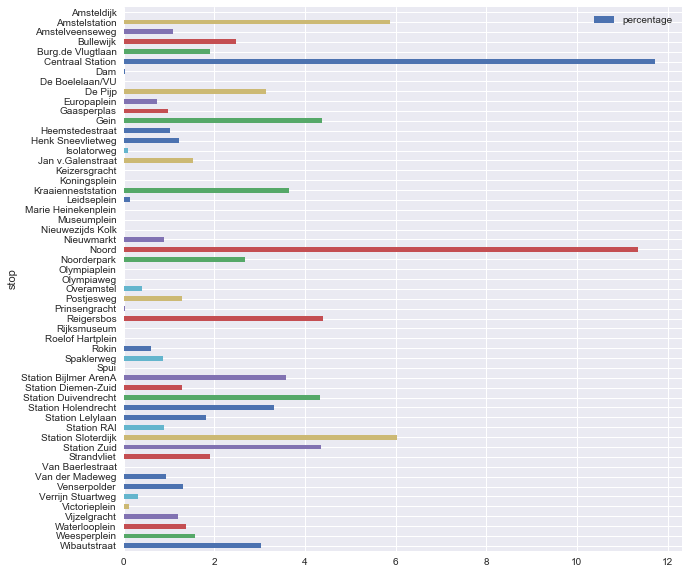

In [15]:
plotgroup('06:00 - 06:59', origingrouped)

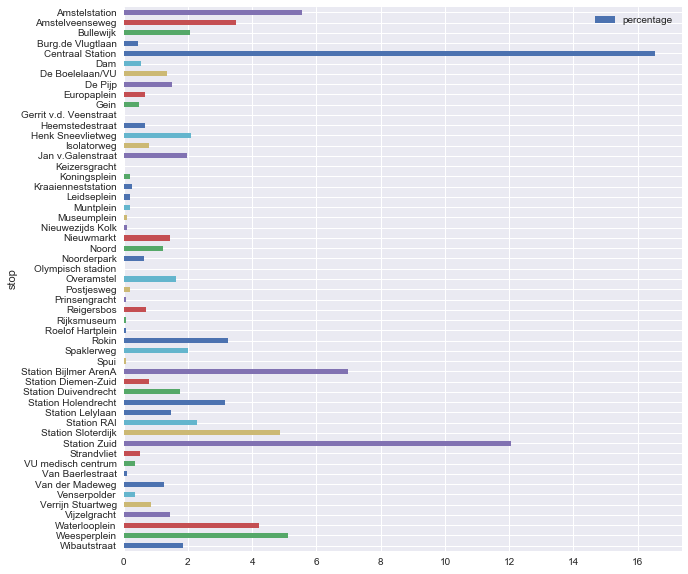

In [16]:
plotgroup('06:00 - 06:59', destinationgrouped)

#### Save distribution for simulation

In [17]:
origingrouped.to_csv('../Data/origin.csv', index=False)
destinationgrouped.to_csv('../Data/destination.csv', index=False)

In [18]:
origin = pd.read_csv("../Data/origin.csv")
destination = pd.read_csv("../Data/destination.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
for hour in hours:
    df = destination[destination['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [31]:
gvborigin['06'][0]

4509.430882352941

In [32]:
total = 0
for i in gvborigin.keys():
    total += gvborigin[i][0]

In [33]:
total

266166.4661764706